# Домашнее задание. Transformers.

Знакомство с моделями трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install -U folium==0.2.1
clear_output()

In [ ]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 346 kB 42.3 MB/s 
     |████████████████████████████████| 6.6 MB 40.8 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 212 kB 41.3 MB/s 
     |████████████████████████████████| 1.1 MB 45.1 MB/s 
     |████████████████████████████████| 140 kB 59.2 MB/s 
     |████████████████████████████████| 127 kB 58.9 MB/s 
     |████████████████████████████████| 144 kB 48.7 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 45.3 MB/s 


In [ ]:
import numpy as np

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

import math
import time

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
device

device(type='cuda', index=0)

In [ ]:
!nvidia-smi

Thu May 26 07:51:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовим класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотрим, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумаем, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text, max_length=self.max_length, padding="max_length", return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'], 
            "attention_mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создадим `train`, `validation` и `test` части датасета. Загрузим их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation') # validation
test_dataset = TweetDataset('test')

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовим оптимайзер и критерий:

In [ ]:
LEARNING_RATE = 2e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
CLIP = 2
N_EPOCHS = 20

optimizer = torch.optim.Adam(model_0.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=2)

'''
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
optimizer = torch.optim.Adam(model_0.parameters(), lr = LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-9, amsgrad=True)
'''

Посмотрим, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
train_data_iter = next(iter(train_loader))
tokens = train_data_iter['input_ids'].squeeze(1).to(device) # Получим токены из датасета
mask = train_data_iter['attention_mask'].squeeze(1).to(device)  # Получим маску из датасета
model_0(input_ids = tokens, attention_mask = mask).keys()  # Посмотрим на аутпут

odict_keys(['logits', 'past_key_values', 'attentions'])

Обучим модель с помощью `train_dataset`, проверяем во время обучения качество с помощью `valid_dataset` и получим финальное качество с помощью `test_dataset`.

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, clip):
    model.train()
    epoch_loss = 0
    accuracy = 0
    target_size = 0
    for batch in iterator:

        targets = batch['target'].to(device)
        tokens = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['attention_mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=tokens,attention_mask=mask,labels=targets).logits
        loss = criterion(outputs,targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = clip)
        optimizer.step()
        #scheduler.step(loss)
        target_size += targets.size(0)
        epoch_loss += loss.cpu().item() * targets.size(0)
        preds = torch.argmax(outputs,dim=1)
        accuracy += torch.sum(preds==targets).cpu()
        
    return epoch_loss / target_size, accuracy / target_size

def evaluate(model, iterator, criterion, scheduler):
    
    model.eval()
    epoch_loss = 0
    accuracy = 0
    target_size = 0
    with torch.no_grad():
        for batch in iterator:
            targets = batch['target'].to(device)
            tokens = batch['input_ids'].squeeze(1).to(device)
            mask  = batch['attention_mask'].squeeze(1).to(device)
            outputs = model(input_ids=tokens,attention_mask=mask,labels=targets).logits
            loss = criterion(outputs,targets)
            scheduler.step(loss)
            target_size += targets.size(0)
            epoch_loss += loss.cpu().item() * targets.size(0)
            preds = torch.argmax(outputs,dim=1)
            accuracy += torch.sum(preds==targets).cpu()
        
    return epoch_loss / target_size, accuracy / target_size

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

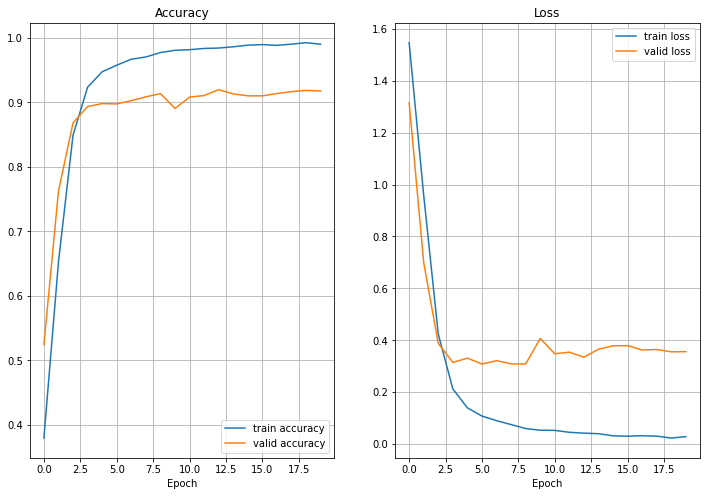

Epoch: 20 | Time: 5m 21s
	Train Loss: 0.029 | Train PPL:   1.029
	 Val. Loss: 0.356 |  Val. PPL:   1.428
	Train Acc: 0.990 | Train PPL:   2.691
	 Val. Acc: 0.918 |  Val. PPL:   2.503


In [ ]:
train_history = []
valid_history = []
train_accuracy = []
valid_accuracy = []

best_valid_acc = .0

for epoch in range(N_EPOCHS):
    torch.cuda.empty_cache()
    start_time = time.time()
    
    train_loss, train_acc = train(model_0, train_loader, optimizer, criterion, scheduler, CLIP)
    valid_loss, valid_acc = evaluate(model_0, valid_loader, criterion, scheduler)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_0.state_dict(), 'best-val-model_0.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    clear_output(True)
    if train_accuracy is not None:
      ax[0].plot(train_accuracy, label='train accuracy')
      ax[0].set_xlabel('Epoch')
      ax[0].set_title('Accuracy')
    if valid_accuracy is not None:
      ax[0].plot(valid_accuracy, label='valid accuracy')
    ax[0].grid()
    ax[0].legend()

    if train_history is not None:
        ax[1].plot(train_history, label='train loss')
        ax[1].set_xlabel('Epoch')
        ax[1].set_title('Loss')
    if valid_history is not None:
        ax[1].plot(valid_history, label='valid loss')
    ax[1].grid()
    ax[1].legend()
    plt.show()

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\tTrain Acc: {train_acc:.3f} | Train PPL: {math.exp(train_acc):7.3f}')
    print(f'\t Val. Acc: {valid_acc:.3f} |  Val. PPL: {math.exp(valid_acc):7.3f}')

In [ ]:
# Testing
model_0.load_state_dict(torch.load('best-val-model_0.pt'))
accuracy = 0
target_size = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        targets = batch['target'].to(device)
        tokens = batch['input_ids'].squeeze(1).to(device)
        mask = batch['attention_mask'].squeeze(1).to(device)
        outputs = model_0(input_ids=tokens,attention_mask=mask,labels=targets).logits
        target_size += targets.size(0)
        preds = torch.argmax(outputs,1)
        accuracy += torch.sum(preds==targets).cpu()

print(f'Test Acc: {round((accuracy / target_size).item(),2)}')

Test Acc: 0.91


После того, как получили лучшую модель для решения этой задачи, посмотрим на карты внимания.

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
text = emotion_dataset["train"]["text"][123] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

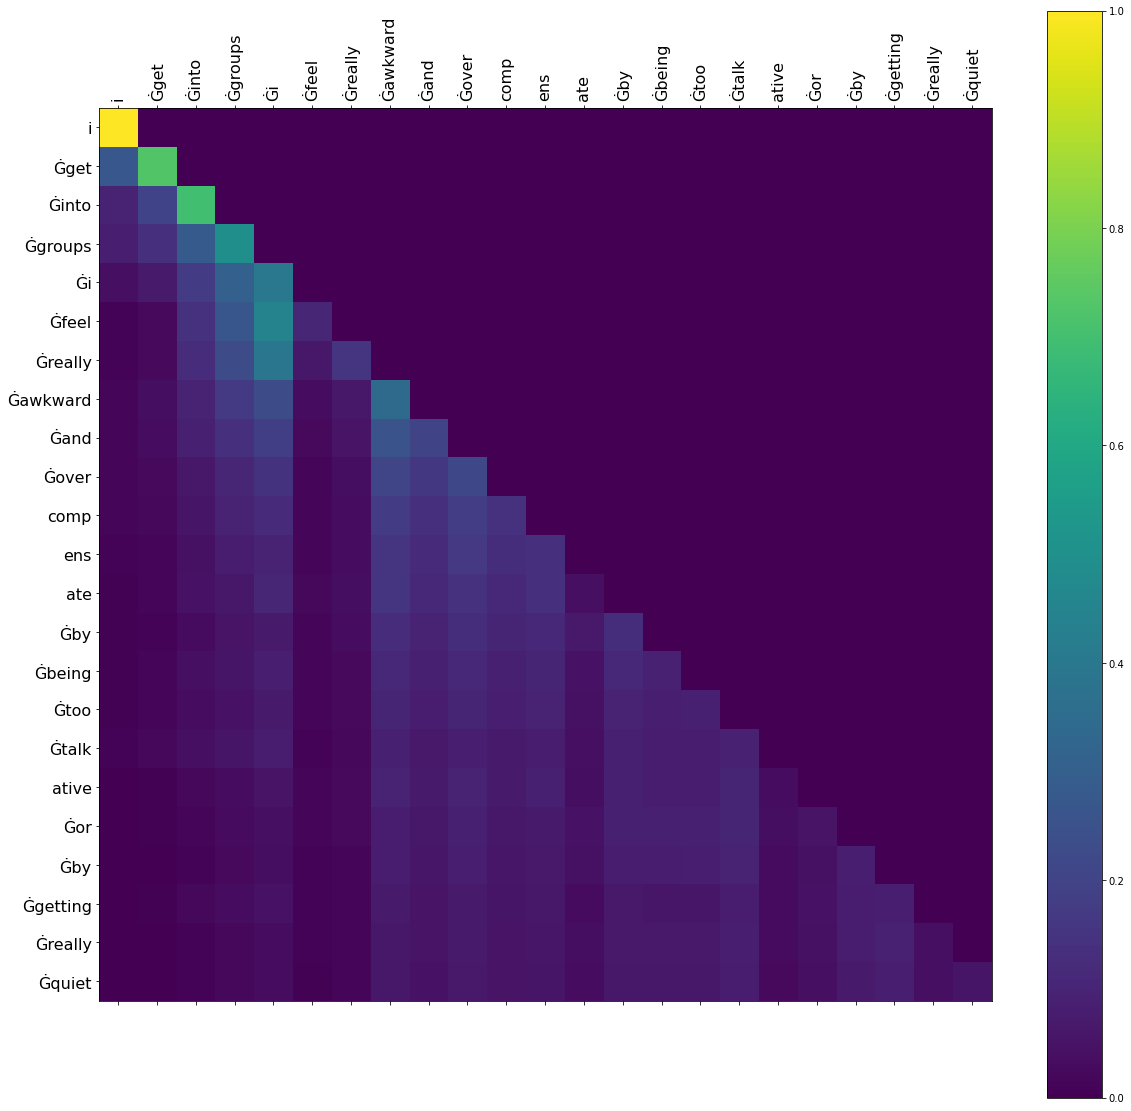

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
N_EPOCHS = 20
CLIP = 2
optimizer = torch.optim.Adam(model_1.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=2)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

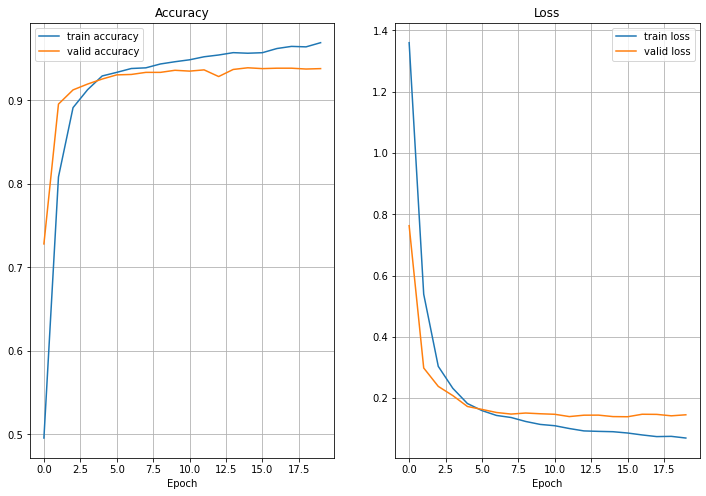

Epoch: 20 | Time: 5m 38s
	Train Loss: 0.070 | Train PPL:   1.072
	 Val. Loss: 0.145 |  Val. PPL:   1.157
	Train Acc: 0.969 | Train PPL:   2.635
	 Val. Acc: 0.938 |  Val. PPL:   2.555


In [ ]:
train_history = []
valid_history = []
train_accuracy = []
valid_accuracy = []

best_valid_acc = 0.0

for epoch in range(N_EPOCHS):
    torch.cuda.empty_cache()
    start_time = time.time()
    
    train_loss, train_acc = train(model_1, train_loader, optimizer, criterion, scheduler, CLIP)
    valid_loss, valid_acc = evaluate(model_1, valid_loader, criterion, scheduler)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_1.state_dict(), 'best-val-model_1.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    clear_output(True)
    if train_accuracy is not None:
      ax[0].plot(train_accuracy, label='train accuracy')
      ax[0].set_xlabel('Epoch')
      ax[0].set_title('Accuracy')
    if valid_accuracy is not None:
      ax[0].plot(valid_accuracy, label='valid accuracy')
    ax[0].grid()
    ax[0].legend()

    if train_history is not None:
        ax[1].plot(train_history, label='train loss')
        ax[1].set_xlabel('Epoch')
        ax[1].set_title('Loss')
    if valid_history is not None:
        ax[1].plot(valid_history, label='valid loss')
    ax[1].grid()
    ax[1].legend()
    plt.show()

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\tTrain Acc: {train_acc:.3f} | Train PPL: {math.exp(train_acc):7.3f}')
    print(f'\t Val. Acc: {valid_acc:.3f} |  Val. PPL: {math.exp(valid_acc):7.3f}')

In [ ]:
# Testing
model_1.load_state_dict(torch.load('best-val-model_1.pt'))
accuracy = 0
target_size = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        targets = batch['target'].to(device)
        tokens = batch['input_ids'].squeeze(1).to(device)
        mask = batch['attention_mask'].squeeze(1).to(device)
        outputs = model_1(input_ids=tokens,attention_mask=mask,labels=targets).logits
        target_size += targets.size(0)
        preds = torch.argmax(outputs,1)
        accuracy += torch.sum(preds==targets).cpu()

print(f'Test Acc: {round((accuracy / target_size).item(),2)}')

Test Acc: 0.93


Есть ли прирост качества или скорости обучения?

Посмотрим на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset["train"]["text"][123] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

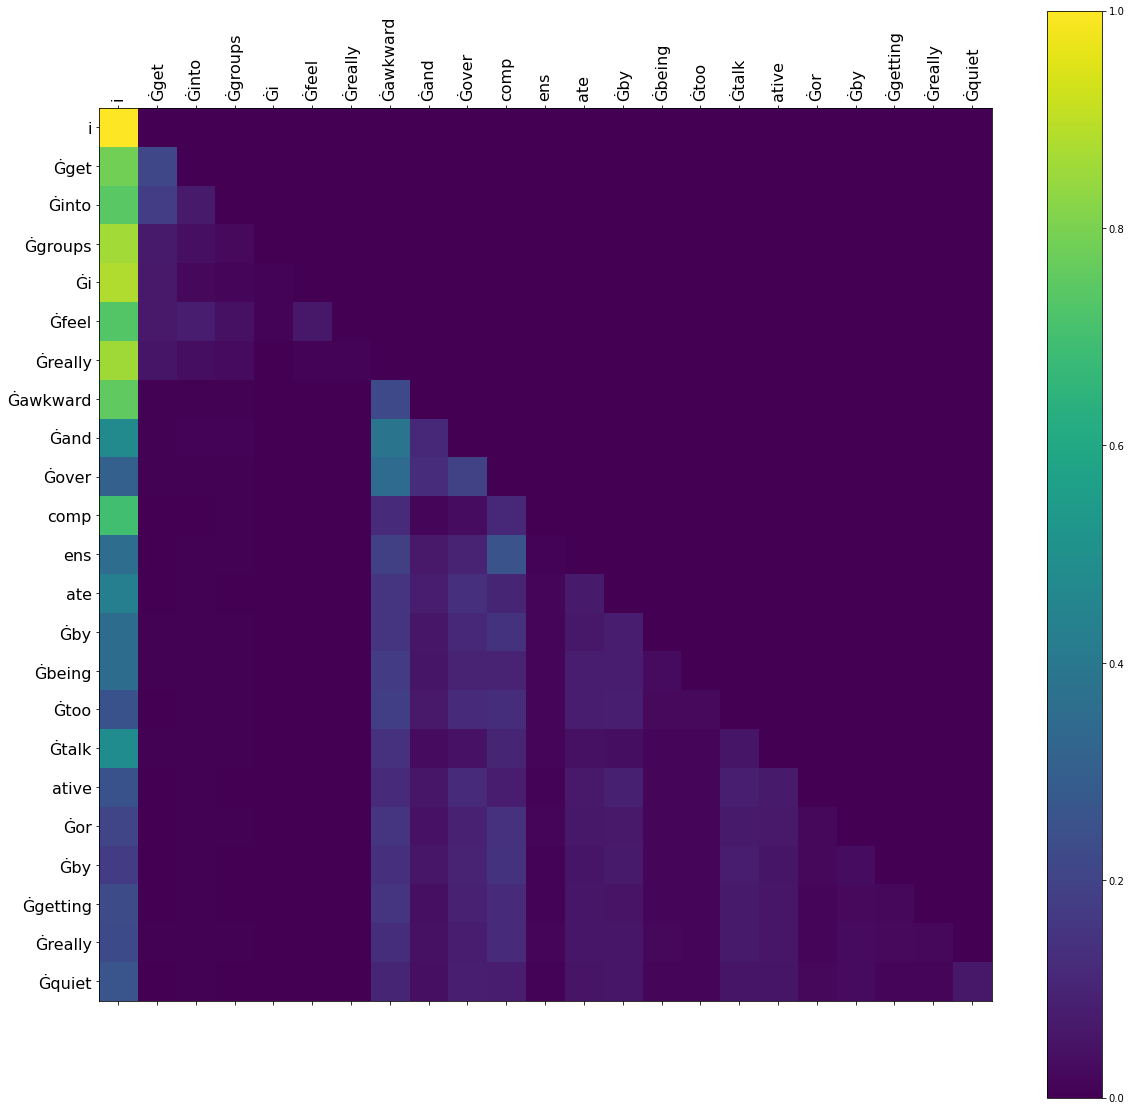

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

<div id="markdownResult" style="background-color: rgb(255, 255, 255); margin: auto; width: 290px;"><table><tbody><tr><th align="center"></th><th align="center"><b>vanilla model</b></th><th align="center"><b>pretrained model</b></th></tr><tr><td align="center">Test Acc:</td><td align="center">0.91</td><td align="center">0.93</td></tr>
</tbody></table></div>

Модель-трансформер, обученная с нуля, на тестовом датасете показала точность 0.91, в то время как модель с предобученными весами показывает 0.93. При этом карты внимания отчетливо указывают на то, что вторая модель с предобученными весами уделяет гораздо больше внимания контексту, связывая слова, находящиеся не только рядом, но и отстающие друг от друга в предложении. Время обучения эпох на стандартном GPU Google Colab у обоих моделей составило 5.5 минут, однако, предобученная модель достигла видимой сходимости за меньшее количество эпох при более плавном изменении функции потерь и точности. Стоит заметить, что сохранение весов по наибольшей валидационной точности, а не по наименьшему валидационному лоссу в данном конкретном случае оказалось более выигрышным решением (что было несколько неожиданным) для достижения максимальных результатов на тестовой выборке. На bertviz-визуализации заметно, что на нулевом слое присутствуют attention-связи между словами с одинаковыми индексами (равномерная "зебра"), которые при увеличении числа слоев и голов начинают фокусироваться, как правило, на самом первом слове и нескольких других в предложении. Первое слово выглядит наиболее доминантным при комплексном рассмотрении всех слоёв\голов.

### Посмотрим визуализацию предобученной модели с помощью bertviz
(далее просто скриншот предобученной модели для наглядности, сам алгоритм вывода написан ниже)

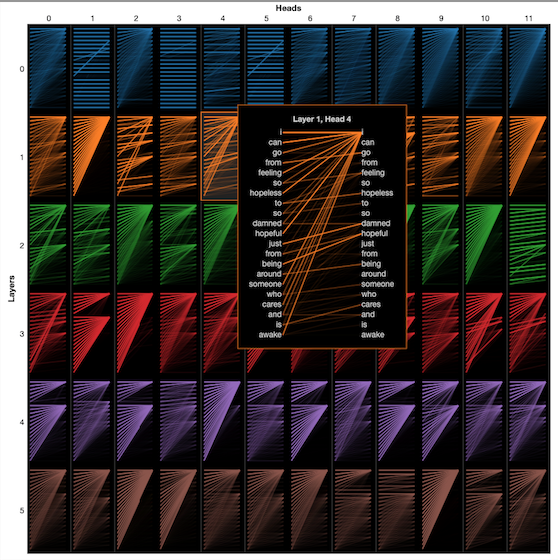

In [ ]:
from google.colab import drive

model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to('cpu')

drive.mount('/content/drive/')
model_1.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/best-val-model_1.pt', map_location=torch.device('cpu')))

In [ ]:
!pip install bertviz
from bertviz import head_view, model_view
clear_output()

In [ ]:
text = emotion_dataset["train"]["text"][1]
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [ ]:
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model_1(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [ ]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>